In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.datasets as ds

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)

%matplotlib inline

In [3]:
# Data reading

data = ds.fetch_openml('credit-g', as_frame=True).frame

data.sample(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
34,>=200,12.0,existing paid,furniture/equipment,1474.0,<100,<1,4.0,female div/dep/mar,none,1.0,life insurance,33.0,bank,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
991,no checking,15.0,all paid,radio/tv,1569.0,100<=X<500,>=7,4.0,male single,none,4.0,car,34.0,bank,own,1.0,unskilled resident,2.0,none,yes,good
222,no checking,12.0,existing paid,radio/tv,707.0,<100,1<=X<4,4.0,male single,none,2.0,real estate,30.0,bank,own,2.0,skilled,1.0,none,yes,good
113,no checking,36.0,critical/other existing credit,new car,7855.0,<100,1<=X<4,4.0,female div/dep/mar,none,2.0,real estate,25.0,stores,own,2.0,skilled,1.0,yes,yes,bad
248,>=200,24.0,existing paid,furniture/equipment,1925.0,<100,1<=X<4,2.0,male single,none,2.0,real estate,26.0,none,own,1.0,skilled,1.0,none,yes,good
325,<0,8.0,critical/other existing credit,new car,3398.0,<100,4<=X<7,1.0,male single,none,4.0,real estate,39.0,none,own,2.0,unskilled resident,1.0,none,no,good
414,<0,24.0,existing paid,new car,1381.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,life insurance,35.0,none,own,1.0,skilled,1.0,none,yes,bad
522,<0,48.0,no credits/all paid,furniture/equipment,7119.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
903,no checking,15.0,existing paid,radio/tv,1386.0,no known savings,1<=X<4,4.0,male mar/wid,none,2.0,real estate,40.0,none,rent,1.0,skilled,1.0,yes,yes,good
215,0<=X<200,6.0,critical/other existing credit,retraining,932.0,no known savings,4<=X<7,1.0,female div/dep/mar,none,3.0,life insurance,39.0,none,own,2.0,unskilled resident,1.0,none,yes,good


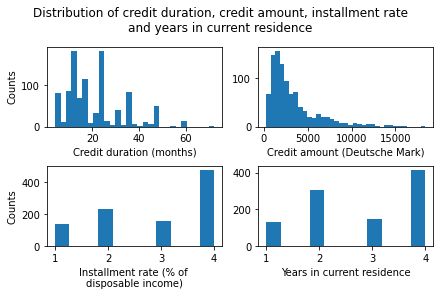

In [4]:
# Distribution of the first four non-categorical features 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of credit duration, credit amount, installment rate\nand years in current residence')

ax[0, 0].hist(data['duration'], bins='auto')
ax[0, 0].set_xlabel('Credit duration (months)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['credit_amount'], bins='auto')
ax[0, 1].set_xlabel('Credit amount (Deutsche Mark)')

ax[1, 0].hist(data['installment_commitment'], bins='auto')
ax[1, 0].set_xlabel('Installment rate (% of \ndisposable income)')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['residence_since'], bins='auto')
ax[1, 1].set_xlabel('Years in current residence')

non_cat_cols = ['duration', 'credit_amount', 'installment_commitment', 'residence_since']

plt.show()

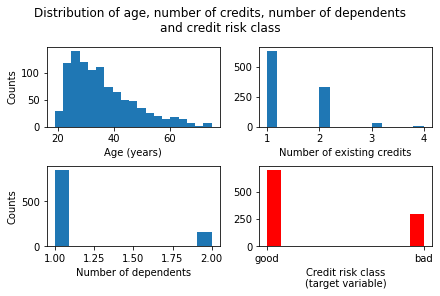

In [5]:
# Distribution of the remaining non-categorical features as well as the target 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of age, number of credits, number of dependents\nand credit risk class')

ax[0, 0].hist(data['age'], bins='auto')
ax[0, 0].set_xlabel('Age (years)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['existing_credits'], bins='auto')
ax[0, 1].set_xlabel('Number of existing credits')

ax[1, 0].hist(data['num_dependents'], bins='auto')
ax[1, 0].set_xlabel('Number of dependents')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['class'], color='r', bins='auto')
ax[1, 1].set_xlabel('Credit risk class\n(target variable)')

non_cat_cols.extend(['age', 'existing_credits', 'num_dependents'])
cat_cols = [col for col in data.columns if col not in non_cat_cols and col != 'class']

plt.show()

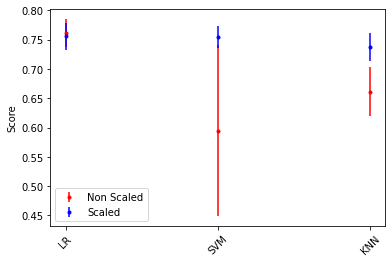

In [6]:
# Train-test-validation split
X = data.loc[:, data.columns != 'class']
y = data['class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0)

# Perform only the required preprocessing of categorical features
X_train_val_trans = pd.get_dummies(X_train_val, columns=cat_cols)

get_score_no_pipe = lambda model: cross_val_score(model, X_train_val_trans, y_train_val)

non_scaled_scores = dict()

non_scaled_scores['LR'] = get_score_no_pipe(LogisticRegression())
non_scaled_scores['SVM'] = get_score_no_pipe(LinearSVC())
non_scaled_scores['KNN'] = get_score_no_pipe(KNeighborsClassifier())

# Creating column transformer and fitting with pipelines
col_trans = ColumnTransformer([
    ('cont', RobustScaler(), ['duration', 'credit_amount', 'age']),
    ('disc', MinMaxScaler(), ['installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']),
    ('cat', OneHotEncoder(), cat_cols)
])

get_score_pipe = lambda model: cross_val_score(make_pipeline(col_trans, model), X_train_val, y_train_val)

scaled_scores = dict()

scaled_scores['LR'] = get_score_pipe(LogisticRegression())
scaled_scores['SVM'] = get_score_pipe(LinearSVC())
scaled_scores['KNN'] = get_score_pipe(KNeighborsClassifier())

# Plotting mean and std of the scores (instead of box plot because we only have 5 samples)
ax = plt.subplot()

ax.set_ylabel('Score')

ax.set_xticklabels(non_scaled_scores.keys(), rotation=45)
ax.set_xticks(range(len(non_scaled_scores)))

ax.errorbar(range(len(non_scaled_scores)),
            np.mean(list(non_scaled_scores.values()), axis=1),
            np.std(list(non_scaled_scores.values()), axis=1), 
            linestyle='None', marker='.', color='r', label='Non Scaled')

ax.errorbar(range(len(scaled_scores)),
            np.mean(list(scaled_scores.values()), axis=1),
            np.std(list(scaled_scores.values()), axis=1), 
            linestyle='None', marker='.', color='b', label='Scaled')

ax.legend()

plt.show()

In [22]:
# Create Pipeline and parameter grid
pipe = Pipeline([
    ('trans', col_trans),
    ('clf', LogisticRegression())
])

col_trans_params = {
    'trans__cont': [StandardScaler(), RobustScaler(), QuantileTransformer(output_distribution='normal')],
    'trans__disc': [MinMaxScaler(), MaxAbsScaler()],
    'trans__cat__drop': [None, 'first']}

param_grid = [
    {**col_trans_params,
     'clf': [LogisticRegression(), LinearSVC()],
     'clf__C': 10 ** np.arange(-2, 4, dtype=float),
     'clf__penalty': [None, 'l1', 'l2']},
    {**col_trans_params,
     'clf': [KNeighborsClassifier()],
     'clf__n_neighbors': np.arange(1, 10),
     'clf__weights': ['uniform', 'distance']}
]

# Perform grid search
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train_val, y_train_val)

print('Best validation score: ', grid.best_score_, '\nBest parameters: ', grid.best_params_, '\nTest score of the best parameters: ', grid.score(X_test, y_test))

Best validation score:  0.7666666666666666 
Best parameters:  {'clf': LinearSVC(C=0.1), 'clf__C': 0.1, 'clf__penalty': 'l2', 'trans__cat__drop': 'first', 'trans__cont': RobustScaler(), 'trans__disc': MaxAbsScaler()} 
Test score of the best parameters:  0.724
